In [1]:
import pandas as pd
data = pd.read_csv("./2025_Problem_C_Data/summerOly_athletes.csv")
print(data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 250985 entries, 0 to 250984
Data columns (total 14 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   Unnamed: 0  250985 non-null  int64 
 1   Name        250985 non-null  object
 2   Sex         250985 non-null  object
 3   Country     250985 non-null  object
 4   NOC         250985 non-null  object
 5   Year        250985 non-null  int64 
 6   City        250985 non-null  object
 7   Sport       250985 non-null  object
 8   Event       250985 non-null  object
 9   Medal       250985 non-null  object
 10  Total       250985 non-null  bool  
 11  Gold        250985 non-null  bool  
 12  Silver      250985 non-null  bool  
 13  Bronze      250985 non-null  bool  
dtypes: bool(4), int64(2), object(8)
memory usage: 20.1+ MB
None


In [2]:
import pandas as pd
df = data
# 假设 df 是包含奥运会数据的 DataFrame
# 按国家、项目、年份分组统计奖牌总数
medal_counts = df.groupby(['Country', 'Sport', 'Year']).size().reset_index(name='TotalMedals')

# 生成所有可能的年份列表
all_years = df['Year'].unique()

# 创建完整的国家-项目-年份组合
full_index = pd.MultiIndex.from_product(
    [medal_counts['Country'].unique(), medal_counts['Sport'].unique(), all_years],
    names=['Country', 'Sport', 'Year']
)
medal_full = medal_counts.set_index(['Country', 'Sport', 'Year']).reindex(full_index, fill_value=0).reset_index()

In [3]:
import ruptures as rpt

def detect_change_point(ts, penalty=10):
    """检测时间序列中的变点"""
    if len(ts) < 2:
        return []
    algo = rpt.Pelt(model="rbf").fit(ts.values)
    change_points = algo.predict(pen=penalty)
    return change_points[:-1]  # 排除最后一个点（序列长度）


results = []

for (country, sport), group in medal_full.groupby(['Country', 'Sport']):
    # 提取时间序列并排序
    ts = group.sort_values('Year')['TotalMedals']
    years = group.sort_values('Year')['Year']
    
    # 检测变点
    cps = detect_change_point(ts)
    
    # 分析每个变点前后的变化
    for cp in cps:
        if cp == 0 or cp >= len(ts) - 1:
            continue
        prev_mean = ts.iloc[:cp].mean()
        post_mean = ts.iloc[cp:].mean()
        change = post_mean - prev_mean
        
        results.append({
            'Country': country,
            'Sport': sport,
            'ChangeYear': years.iloc[cp],
            'PreviousMean': prev_mean,
            'PostMean': post_mean,
            'Change': change
        })
        
# 转换为 DataFrame
results_df = pd.DataFrame(results)

# 筛选变化显著的案例（例如：变化幅度超过阈值）
threshold = 3  # 假设奖牌数变化超过3
significant_changes = results_df[
    (results_df['Change'].abs() > threshold) |
    ((results_df['PreviousMean'] == 0) & (results_df['PostMean'] > 0)) |
    ((results_df['PostMean'] == 0) & (results_df['PreviousMean'] > 0))
].sort_values('Change', ascending=False)

In [4]:
significant_changes

,Country,Sport,ChangeYear,PreviousMean,PostMean,Change
2,Australia,Swimming,1964,12.133333,78.000000,65.866667
9,China,Swimming,1984,0.250000,59.272727,59.022727
15,Kenya,Athletics,1984,4.850000,41.636364,36.786364
1,Australia,Hockey,1984,4.600000,32.727273,28.127273
8,China,Shooting,1984,0.000000,27.272727,27.272727
16,Netherlands,Hockey,1984,6.450000,32.727273,26.277273
6,China,Fencing,1984,0.000000,25.000000,25.000000
4,Brazil,Volleyball,1964,0.000000,20.937500,20.937500
7,China,Rowing,1984,0.000000,19.272727,19.272727
10,China,Volleyball,1984,0.000000,13.727273,13.727273


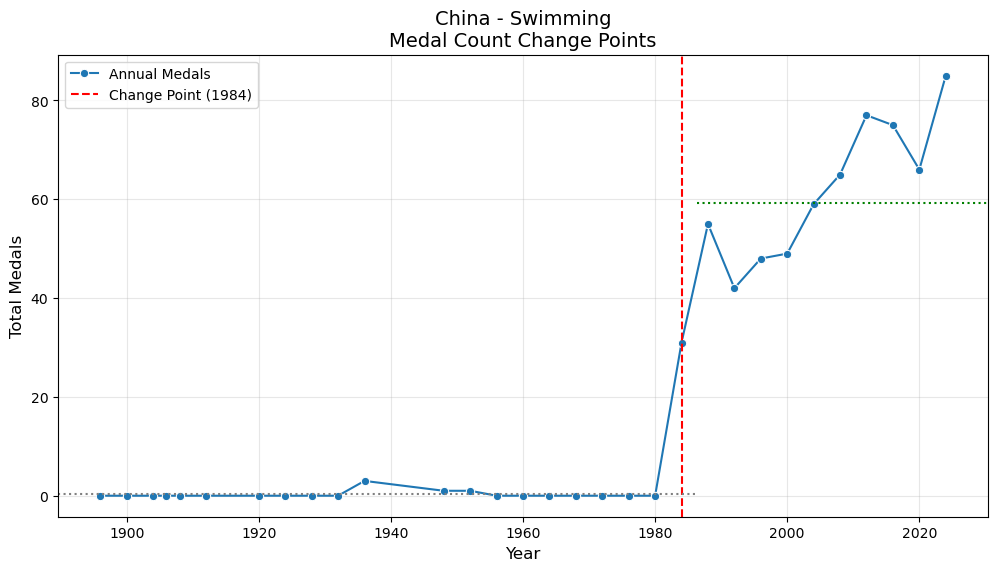

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_change_points(results_df, medal_full, country, sport):
    """绘制指定国家-项目的时间序列及变点"""
    # 提取该国家-项目的数据
    data = medal_full[(medal_full['Country'] == country) & 
                      (medal_full['Sport'] == sport)].sort_values('Year')
    
    # 提取对应的变点信息
    changes = results_df[(results_df['Country'] == country) & 
                         (results_df['Sport'] == sport)]
    
    # 创建画布
    plt.figure(figsize=(12, 6))
    
    # 绘制奖牌数折线图
    sns.lineplot(data=data, x='Year', y='TotalMedals', 
                 marker='o', label='Annual Medals')
    
    # 标注变点
    for _, row in changes.iterrows():
        change_year = row['ChangeYear']
        prev_mean = row['PreviousMean']
        post_mean = row['PostMean']
        
        # 绘制变点垂直线
        plt.axvline(change_year, color='red', linestyle='--', 
                    label=f'Change Point ({change_year})')
        
        # 绘制突变前后的平均线
        plt.axhline(prev_mean, color='grey', linestyle=':', 
                    xmax=(change_year - data['Year'].min()) / (data['Year'].max() - data['Year'].min()))
        plt.axhline(post_mean, color='green', linestyle=':', 
                    xmin=(change_year - data['Year'].min()) / (data['Year'].max() - data['Year'].min()))
    
    # 添加标题和标签
    plt.title(f"{country} - {sport}\nMedal Count Change Points", fontsize=14)
    plt.xlabel("Year", fontsize=12)
    plt.ylabel("Total Medals", fontsize=12)
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()

# 示例调用
plot_change_points(significant_changes, medal_full, "China", "Swimming")

Generating Plots:  91%|█████████ | 20/22 [00:04<00:00,  4.88it/s]C:\Users\86137\AppData\Local\Temp\ipykernel_35852\1850404236.py:29: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure(figsize=(10, 5))
Generating Plots: 100%|██████████| 22/22 [00:04<00:00,  4.41it/s]


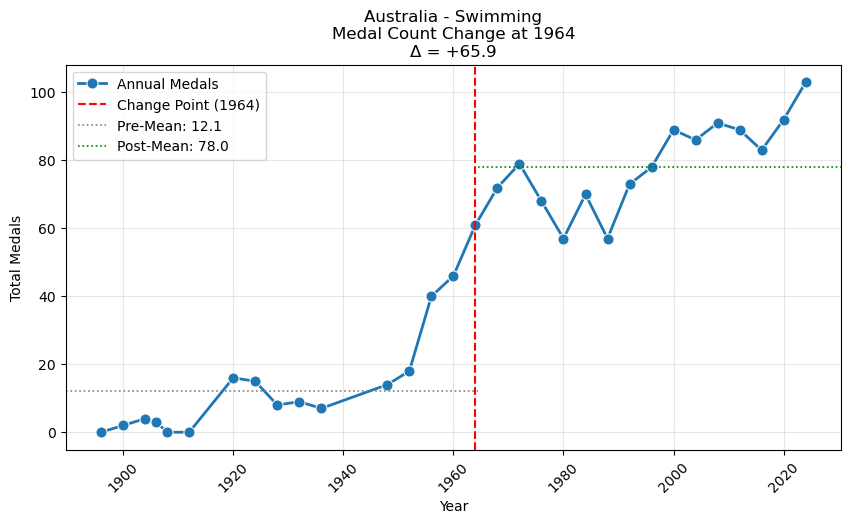

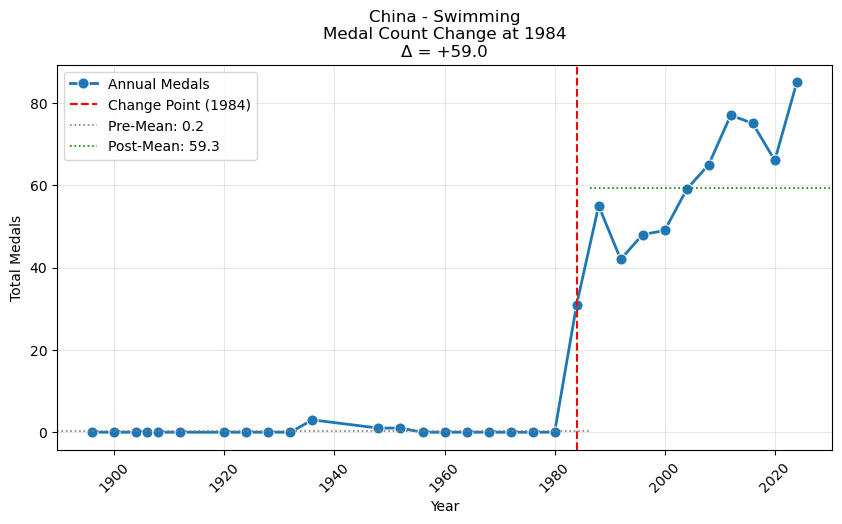

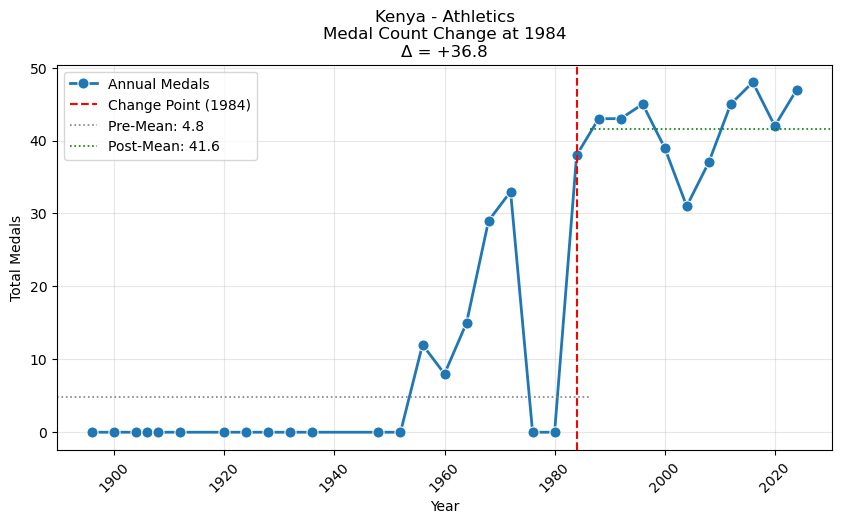

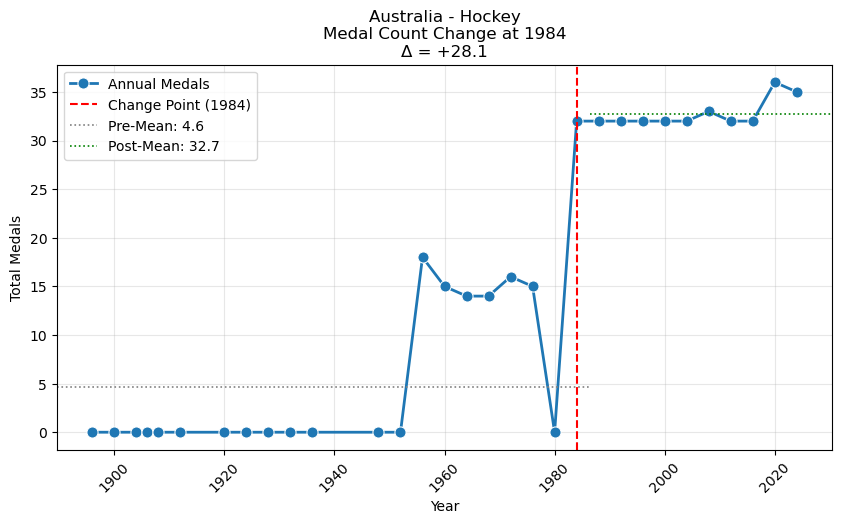

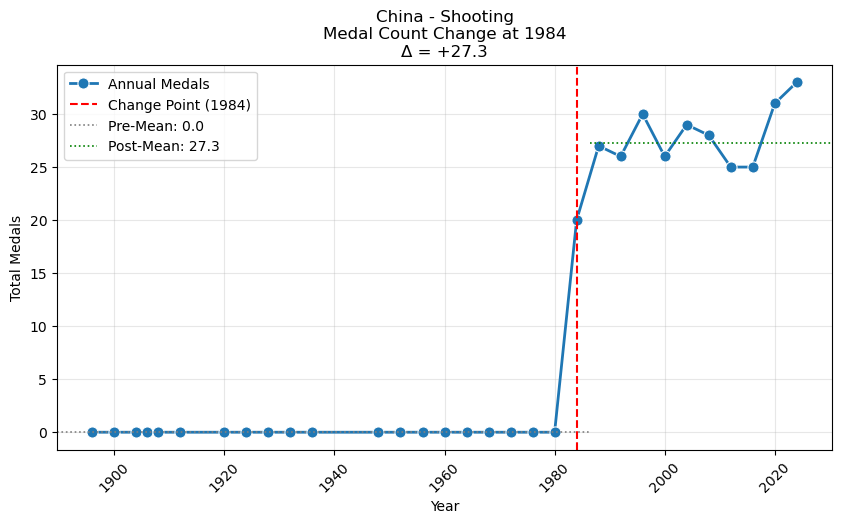

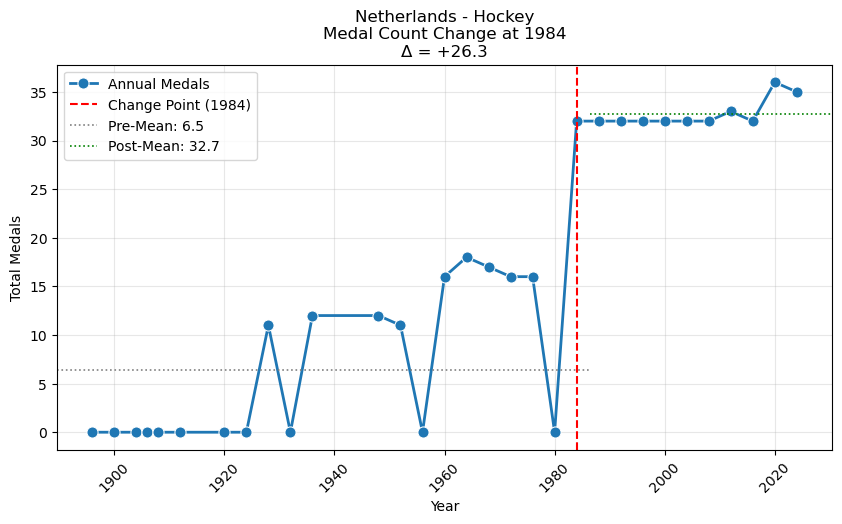

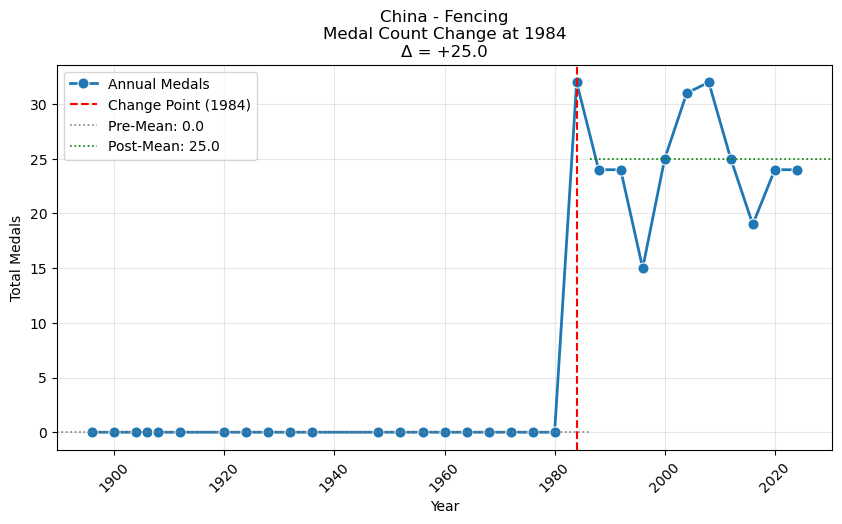

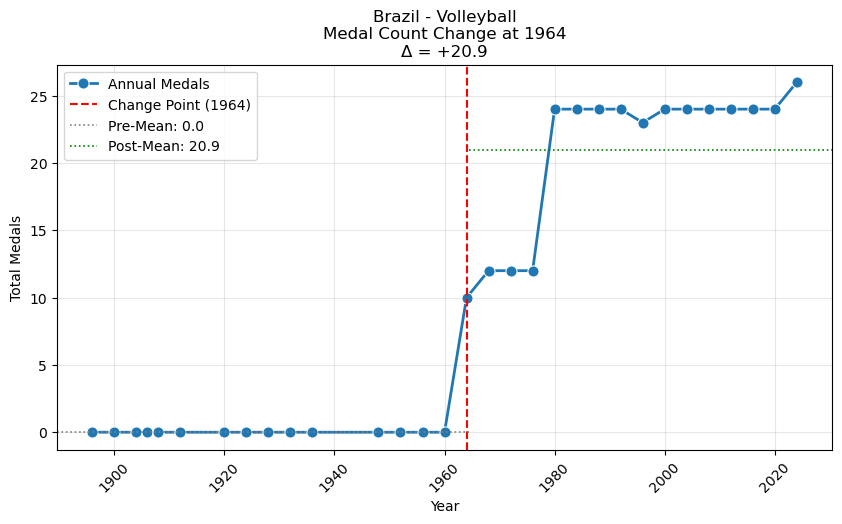

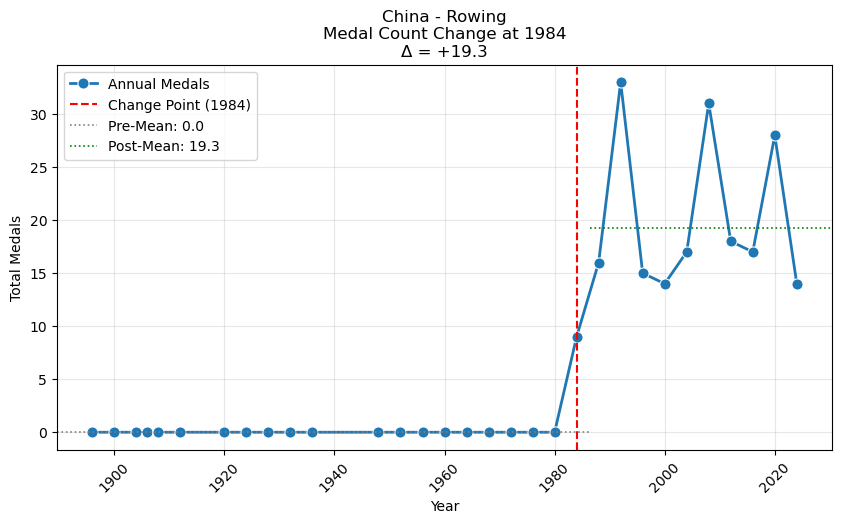

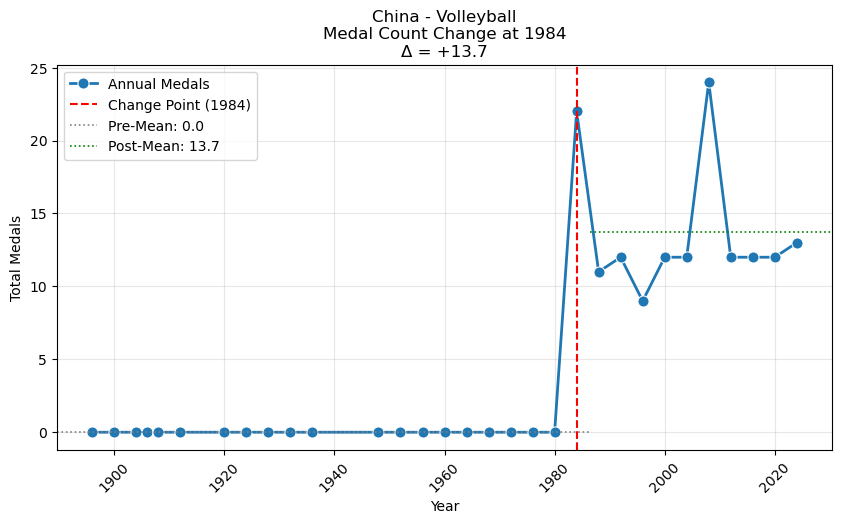

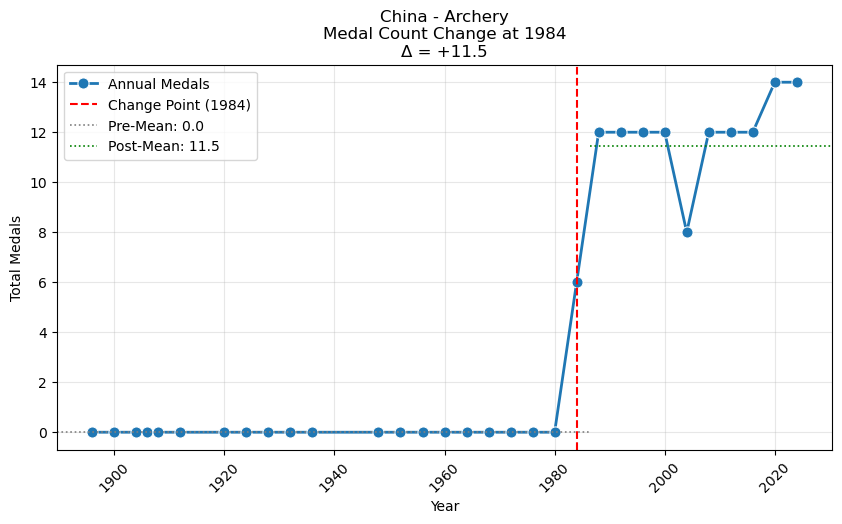

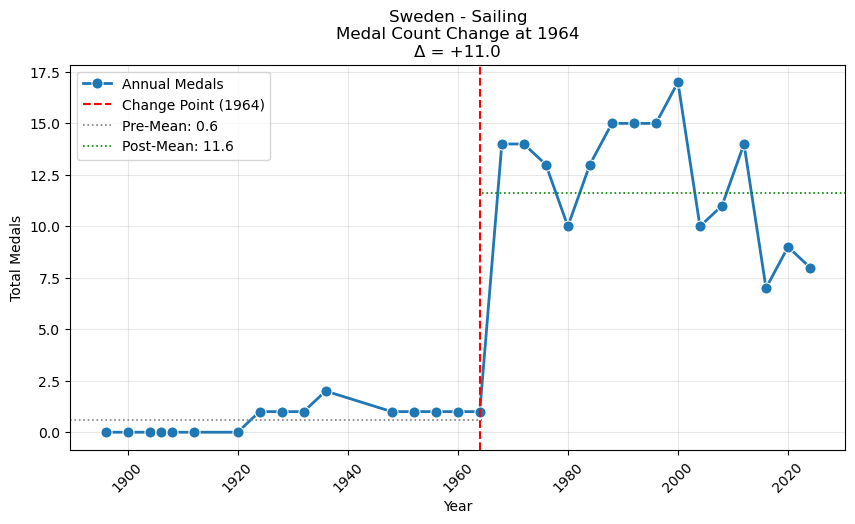

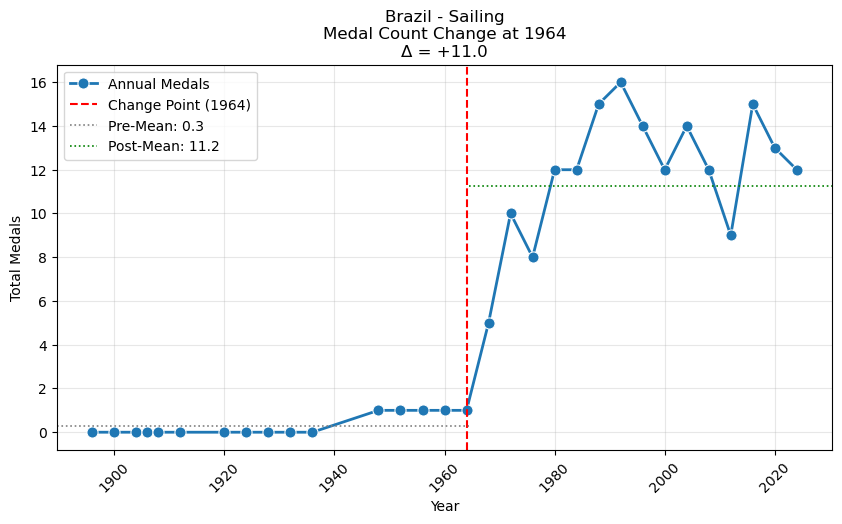

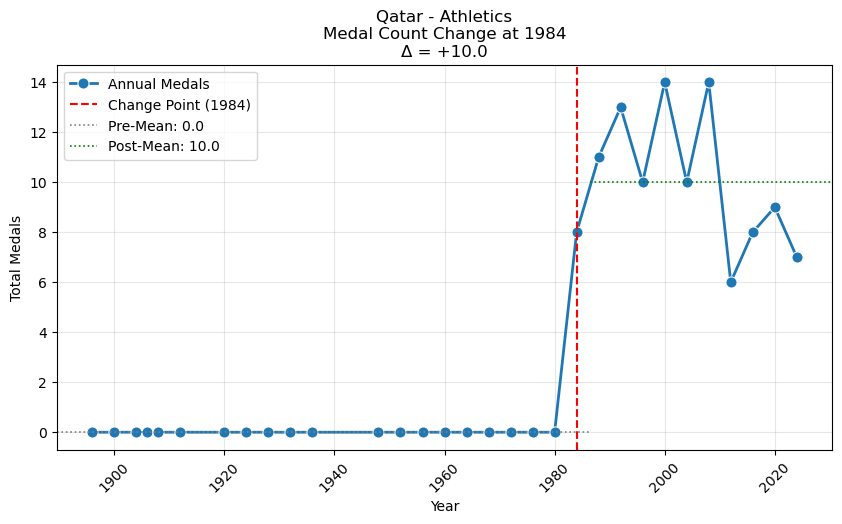

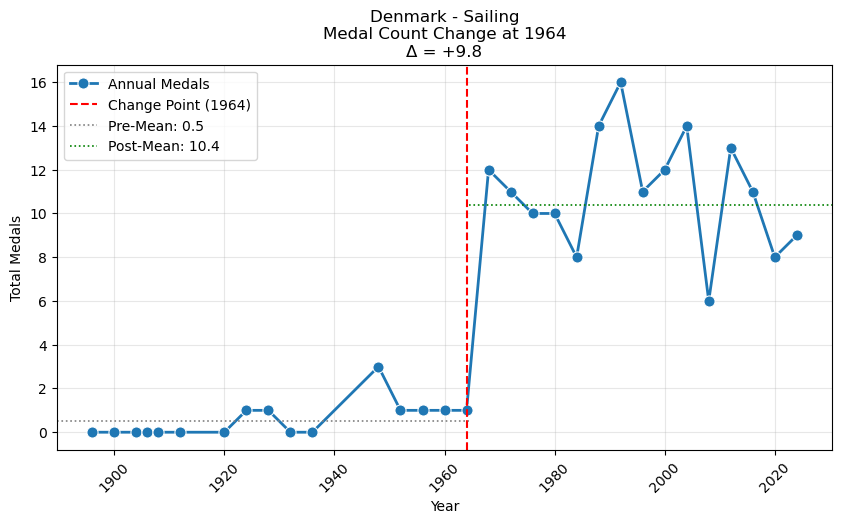

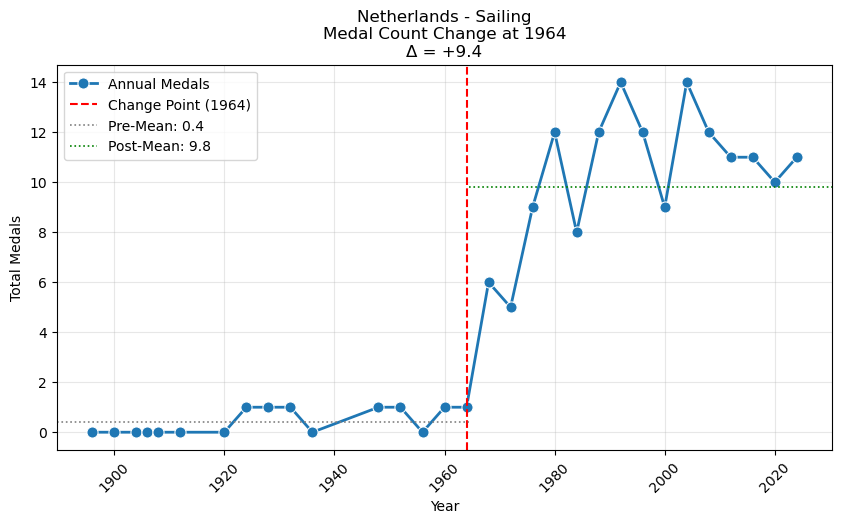

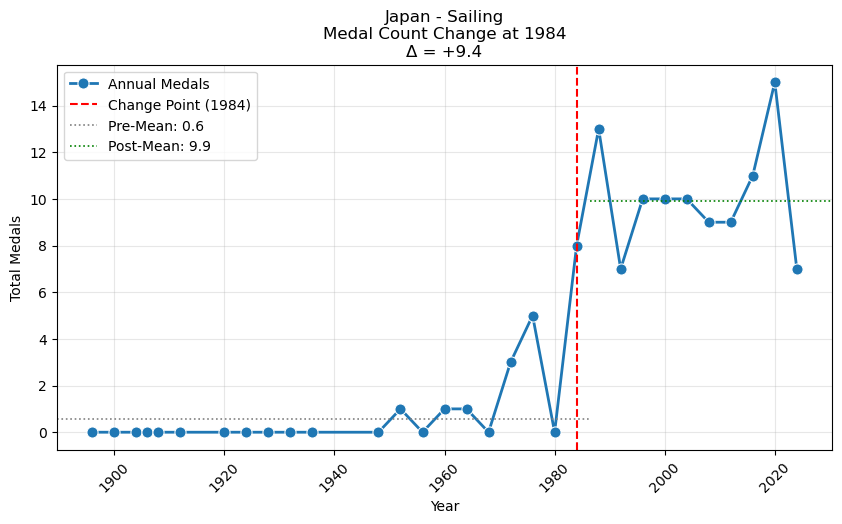

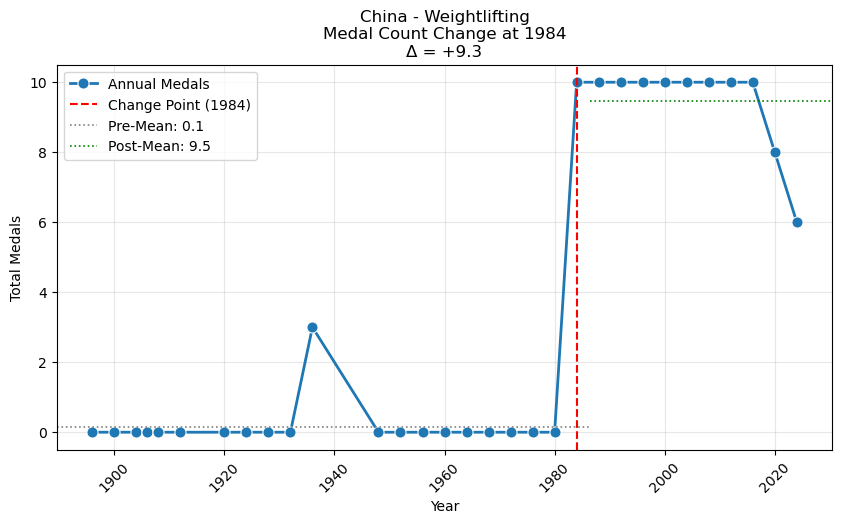

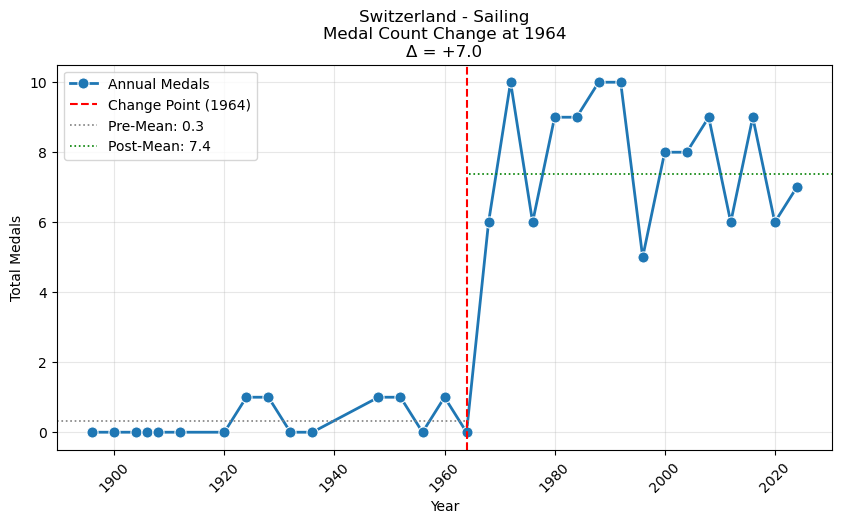

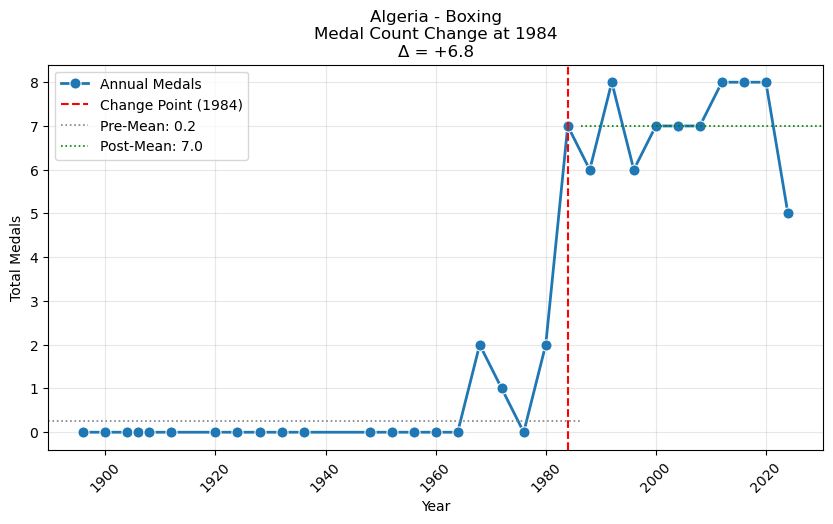

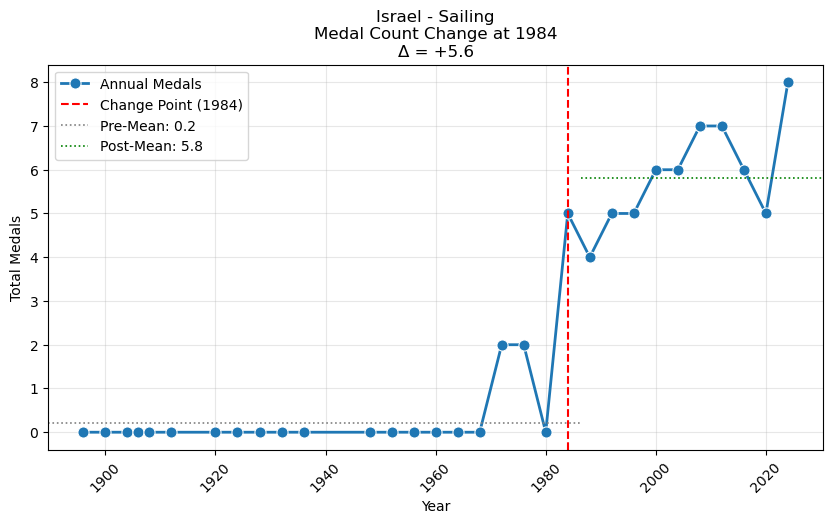

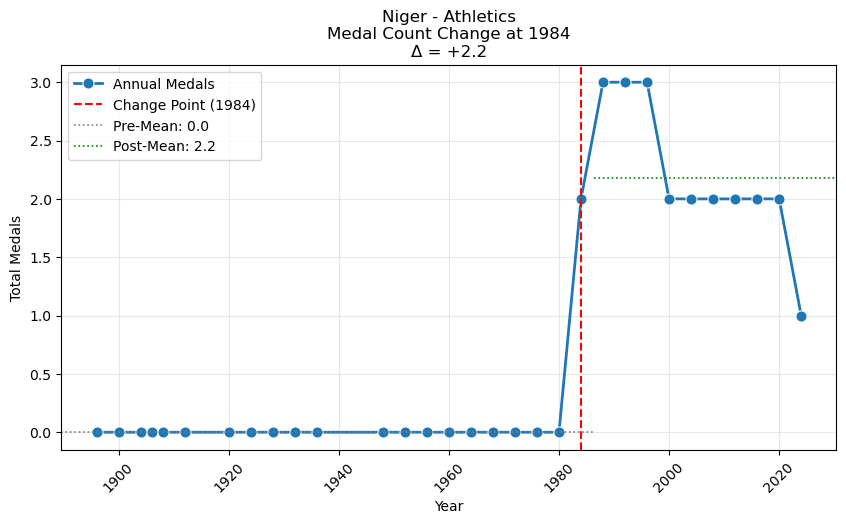

In [8]:
import os
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm  # 进度条工具

def plot_all_change_points(results_df, medal_full, output_dir="change_points_plots"):
    """批量绘制所有显著变点的时间序列"""
    # 创建输出目录
    os.makedirs(output_dir, exist_ok=True)
    
    # 使用进度条
    for idx, row in tqdm(results_df.iterrows(), total=len(results_df), desc="Generating Plots"):
        country = row['Country']
        sport = row['Sport']
        change_year = row['ChangeYear']
        
        try:
            # 提取对应数据
            data = medal_full[
                (medal_full['Country'] == country) & 
                (medal_full['Sport'] == sport)
            ].sort_values('Year').reset_index(drop=True)
            
            # 跳过数据不足的情况
            if len(data) < 5:  # 至少需要5个数据点才有分析意义
                continue
                
            # 创建画布
            plt.figure(figsize=(10, 5))
            
            # 绘制主要趋势线
            sns.lineplot(
                x=data['Year'], 
                y=data['TotalMedals'], 
                marker='o',
                color='#1f77b4',
                linewidth=2,
                markersize=8,
                label='Annual Medals'
            )
            
            # 标注变点
            plt.axvline(
                change_year, 
                color='red', 
                linestyle='--', 
                linewidth=1.5,
                label=f'Change Point ({change_year})'
            )
            
            # 计算前后均值
            prev_data = data[data['Year'] < change_year]
            post_data = data[data['Year'] >= change_year]
            prev_mean = prev_data['TotalMedals'].mean() if not prev_data.empty else 0
            post_mean = post_data['TotalMedals'].mean() if not post_data.empty else 0
            
            # 绘制均值线
            plt.axhline(
                prev_mean, 
                color='gray', 
                linestyle=':', 
                linewidth=1.2,
                xmax=(change_year - data['Year'].min()) / (data['Year'].max() - data['Year'].min()),
                label=f'Pre-Mean: {prev_mean:.1f}'
            )
            plt.axhline(
                post_mean, 
                color='green', 
                linestyle=':', 
                linewidth=1.2,
                xmin=(change_year - data['Year'].min()) / (data['Year'].max() - data['Year'].min()),
                label=f'Post-Mean: {post_mean:.1f}'
            )
            
            # 添加标注
            plt.title(
                f"{country} - {sport}\n"
                f"Medal Count Change at {change_year}\n"
                f"Δ = {post_mean - prev_mean:+.1f}",
                fontsize=12
            )
            plt.xlabel("Year", fontsize=10)
            plt.ylabel("Total Medals", fontsize=10)
            plt.xticks(rotation=45)
            plt.grid(alpha=0.3)
            plt.legend(loc='upper left')
            
            # 保存图片
            #filename = f"{country}_{sport}_{change_year}.png".replace("/", "-")  # 处理特殊字符
            #plt.savefig(
            #    os.path.join(output_dir, filename), 
            #    dpi=150, 
            #    bbox_inches='tight'
            #)
            #plt.close()
            
        except Exception as e:
            print(f"Error processing {country}-{sport}: {str(e)}")
            continue

# 执行批量生成
plot_all_change_points(significant_changes, medal_full)